# FULL-SKY SYNTHETIC SKY CATALOG 
## Based on HACC Dark matter simulation products and stellar population synthesis. Contains SEDs, RA-Dec coordinates, bandpasses from multiple surveys (SPHEREx, SDSS, COSMOS) etc.

In [ ]:
import h5py
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import pandas as pd
from mpl_toolkits.basemap import Basemap
# plt.style.use('dark_background')
from astropy import units as u
from astropy.coordinates import SkyCoord

colorList = np.array(list(mcolors.TABLEAU_COLORS.items()))[:, 1]

### Download the catalog from https://portal.nersc.gov/project/hacc/spherex_sky/ 
### (or directly from NERSC-Perlmutter:/global/cfs/cdirs/hacc/www/spherex_sky, if you have access)

## **Catalog entries**

---

- **ra_full**: *Right ascension coordinates of the galaxies on the full sky*
- **dec_full**: *Declination coordinates of the galaxies on the full sky*
- **redshift_true**: *Redshift of the galaxies*
- **SED**: *Spectral energy distributions in [Jy]*
- **SED_wavelength**: *Wavelength of the spectra in [A]*
- **mag_\<n\>_spherex**: *SPHEREx bandpasses in n:0-196*
- **mag_\<n\>_cosmos**: *COSMOS magnitudes in n:1-30*
- **mag_\<x\>_sdss**: *SDSS magnitudes for x: {u, g, r, i, z, Y}*
- **halo_mass**: *Total mass of the host halo in [Msun/h]*
- **stellar_mass**: *Stellar mass of the galaxy in [Msun/h]*
- **ra_true**: *Right ascension coordinates of the galaxies on the original octant*
- **dec_true**: *Declination coordinates of the galaxies on the original octant*
- **position_x**: *x-coordinate of the host core in [Mpc/h]*
- **position_y**: *y-coordinate of the host core in [Mpc/h]*
- **position_z**: *z-coordinate of the host core in [Mpc/h]*
- **is_central**: *Type of the host core: Central=1, Satellite=0*
- **SFH**: *Star formation history of the galaxy*
- **time_bins_SFH**: *Time bins for the SFH in [Gyr]*
- **galaxy_id**: *Galaxy ID*
- **halo_id**: *Host core ID*
- **luminosity**: *Luminosity of the galaxy (to be corrected)*

## Reading all attributes from the catalog, removing a few invalid entries (magnitude issues)

In [ ]:
def read_and_clean_catalog(catalog_name):
    with h5py.File(catalog_name, 'r') as f:
        items = list(f.keys())
        raw_data = {}
        for item in items:
            if isinstance(f[item], h5py.Dataset):
                raw_data[item] = f[item][()]
            elif isinstance(f[item], h5py.Group):
                group_data = {}
                for sub_item in f[item].keys():
                    group_data[sub_item] = f[item][sub_item][()]
                raw_data[item] = group_data
                
        f.close()

    # Identify invalid entries across all datasets starting with "mag_"
    mag_invalid_indices = set()

    for key, value in raw_data.items():
        if key.startswith("mag_") and isinstance(value, np.ndarray):  # Check only for magnitude datasets
            invalid_indices = np.where(np.isinf(value) | np.isnan(value))[0]
            mag_invalid_indices.update(invalid_indices)

    # Convert set to numpy array
    mag_invalid_indices = np.array(list(mag_invalid_indices))

    # Remove rows with invalid entries from all datasets
    cleaned_data = {}
    for key, value in raw_data.items():
        if isinstance(value, np.ndarray):  # Check only for datasets (not groups)
            valid_indices = mag_invalid_indices[mag_invalid_indices < len(value)]
            cleaned_value = np.delete(value, valid_indices, axis=0)
            cleaned_data[key] = cleaned_value
            
    print('Total number of galaxies: %d'%len(cleaned_data[items[3]]))  # Displaying the length of mag_i_sdss as an example

    return cleaned_data, items

## Reading the file

In [ ]:
# Testing the updated function on the provided file
catalog_name = 'SED_catalog_combined_v27_swing.hdf5'
Vol = 256**3
test_data, test_items = read_and_clean_catalog(catalog_name)

Total number of galaxies: 491431


### Accessing desired catalog entries

In [ ]:
ra_full = np.array(test_data['ra_full'])
dec_full = np.array(test_data['dec_full'])
redshift = np.array(test_data['redshift_true'])
halo_mass = np.array(test_data['halo_mass'])
stellar_mass = np.array(test_data['stellar_mass'])
is_central = np.array(test_data['is_central'])

wavelength = np.array(test_data['SED_wavelength']) #this is rest frame wavelength
SEDs = np.array(test_data['SED'])
luminosity = np.array(test_data['luminosity']) #incorrect calculation

mag_u = np.array(test_data['mag_u_sdss'])
mag_g = np.array(test_data['mag_g_sdss'])
mag_r = np.array(test_data['mag_r_sdss'])
mag_i = np.array(test_data['mag_i_sdss'])
mag_z = np.array(test_data['mag_z_sdss'])
mag_Y = np.array(test_data['mag_Y_sdss'])

## Sample analyses using the catalog

### 1. Sky distribution using the mollweide projection

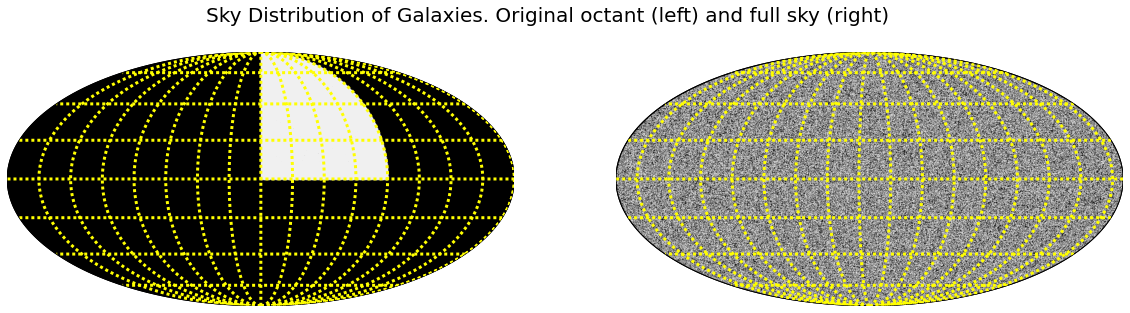

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(122)

# Define the orthographic projection centered on the equator and prime meridian
m = Basemap(projection='moll', lat_0=20, lon_0=105, resolution='c')

# Convert RA, Dec to x, y coordinates for plotting
x, y = m(ra_full, dec_full)

# Plot the sky distribution
m.scatter(x, y, s=1, c='white', alpha=0.08, edgecolors='w', linewidth=0.5)

# Draw parallels and meridians
m.drawparallels(np.arange(-90.,90.,22.5), color='yellow', textcolor='yellow', linewidth=3)
m.drawmeridians(np.arange(0.,360.,22.5), color='yellow', textcolor='yellow', linewidth=3)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color='black', linewidth=0.5)

##########################
ax = fig.add_subplot(121)

ra_octant = np.array(test_data['ra_true'])
dec_octant = np.array(test_data['dec_true'])

# Define the orthographic projection centered on the equator and prime meridian
m = Basemap(projection='moll', lat_0=-60, lon_0=90, resolution='c')
# Convert RA, Dec to x, y coordinates for plotting
x, y = m(ra_octant, dec_octant)

# Plot the sky distribution
m.scatter(x, y, s=1, c='white', alpha=0.08, edgecolors='w', linewidth=0.5)

# Draw parallels and meridians
m.drawparallels(np.arange(-90.,90.,22.5), color='yellow', textcolor='yellow', linewidth=3)
m.drawmeridians(np.arange(0.,360.,22.5), color='yellow', textcolor='yellow', linewidth=3)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color='black', linewidth=0.5)
 
plt.suptitle('Sky Distribution of Galaxies. Original octant (left) and full sky (right)', fontsize=20)
plt.show()

### 2. Halo mass function, stellar mass function and Stellar mass-to-halo mass relationship

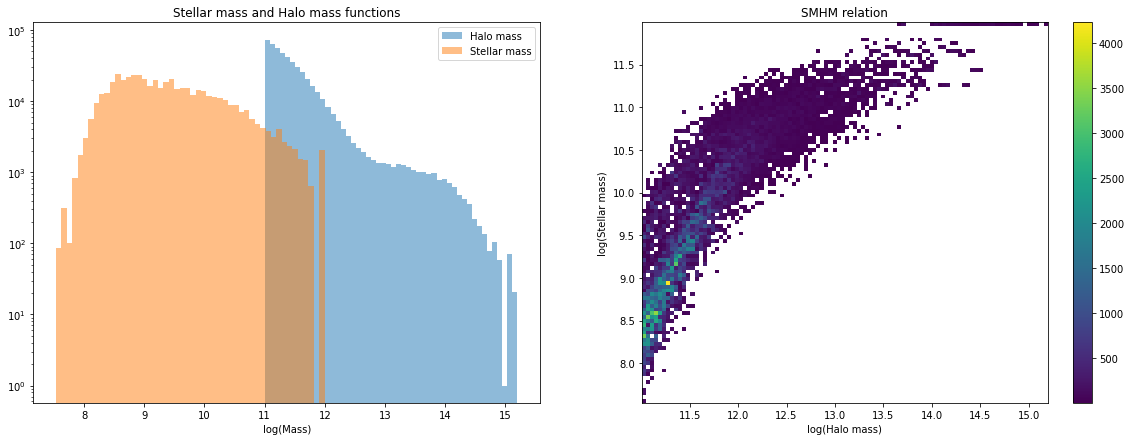

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)

ax.set_title('Stellar mass and Halo mass functions')
ax.hist(np.log10(halo_mass), bins=50, alpha=0.5, label='Halo mass');
ax.hist(np.log10(stellar_mass), bins=50, alpha=0.5, label='Stellar mass');
ax.set_yscale('log')
ax.set_xlabel('log(Mass)')
ax.legend()

ax = fig.add_subplot(122)
_, _, _, im = ax.hist2d(np.log10(halo_mass), np.log10(stellar_mass), bins=(100, 100), cmin = 1)

ax.set_title('SMHM relation')
ax.set_xlabel('log(Halo mass)')
ax.set_ylabel('log(Stellar mass)')
plt.colorbar(im)

plt.show()

### 3. SEDs of randomly chosen galaxies

Text(0.5, 1.0, 'Narrow band SEDs of a few galaxies')

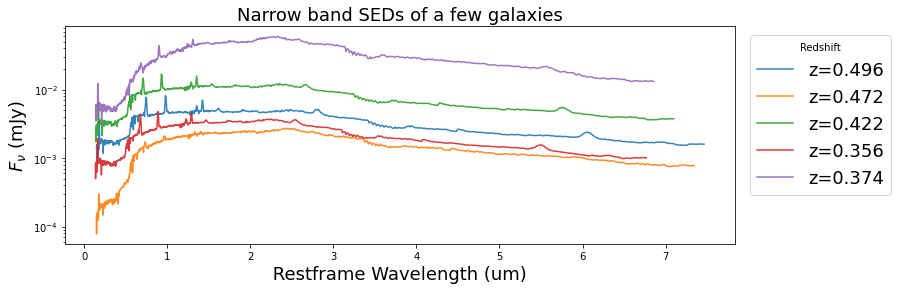

In [ ]:
np.random.seed(8)
galID_arr = np.random.randint(low=0, high=SEDs.shape[0], size=5)

plt.figure(figsize=(12,4))

for idx, galID in enumerate(galID_arr):    
    
    obs_frame_wave = wavelength*(1 + redshift[galID])
    plt.plot(obs_frame_wave/1e4 , 
             SEDs[galID]*1e3, 
             label='z=%.3f'%redshift[galID], 
             color=colorList[idx],
             alpha=0.9);

plt.ylabel(r'$F_\nu$ (mJy)', fontsize=18)
plt.xlabel(' Restframe Wavelength (um) ', fontsize=18)
plt.yscale('log')
plt.legend(ncol=1, title='Redshift', fontsize=18, bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.title('Narrow band SEDs of a few galaxies', fontsize=18)

### 4. Color-redshift relationship for Central galaxies (SDSS-r and SDSS-i bands)

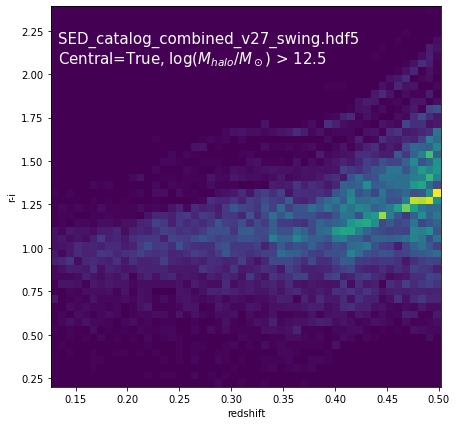

In [ ]:
color_ri = mag_r - mag_i
mass_cut = 12.5
cond = np.where( (is_central==True) & ( np.log10(halo_mass) > mass_cut) ) 

redshift_select = redshift[cond]
ri_select = color_ri[cond]

f, ax = plt.subplots(1,1, figsize =(7, 7))
plt.hist2d(x=redshift_select, y=ri_select, bins=50);
plt.xlabel('redshift')
plt.ylabel('r-i')
plt.text(x=0.02, y=0.85, s='%s \nCentral=True, log($M_{halo}/M_\odot$) > %.1f'%(catalog_name, mass_cut), color='w', 
         transform=ax.transAxes, fontsize=15)
plt.show()

### 5. SDSS magnitude distributions

<matplotlib.legend.Legend>

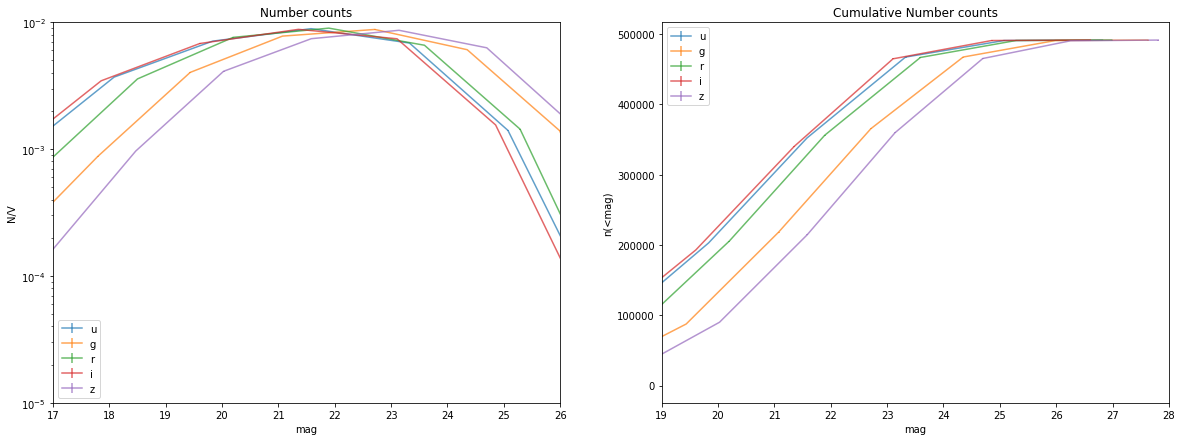

In [ ]:
def plt_errorbar(x, label):
    y, bin_edges = np.histogram(x, bins = 50)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers, y/Vol, yerr = (y**0.5)/Vol, label=label, alpha=0.7) 
    
def plt_cumulative(x, label):
    y, bin_edges = np.histogram(x, bins = 50)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    y_cumulative = np.cumsum(y)
    plt.errorbar(bin_centers, y_cumulative, yerr = (y_cumulative**0.5), label=label, alpha=0.7) 
    plt.xlim(19, 28)
    
    
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)


plt_errorbar(mag_u, 'u')
plt_errorbar(mag_g, 'g')
plt_errorbar(mag_r, 'r')
plt_errorbar(mag_i, 'i')
plt_errorbar(mag_z, 'z')
plt.title('Number counts')
plt.xlabel('mag')
plt.ylabel('N/V')
plt.xlim(17, 26)
plt.ylim(1e-5, 1e-2)
plt.yscale('log')
plt.legend()


ax = fig.add_subplot(122)

# plt.figure(figsize=(9, 5))
plt_cumulative(mag_u, 'u')
plt_cumulative(mag_g, 'g')
plt_cumulative(mag_r, 'r')
plt_cumulative(mag_i, 'i')
plt_cumulative(mag_z, 'z')
plt.title('Cumulative Number counts')
plt.xlabel('mag')
plt.ylabel('n(<mag)')
plt.xlim(19, 28)
plt.legend()

### 6. Color-redshift relationship for Central galaxies (SDSS-r and SDSS-i bands)

<matplotlib.legend.Legend>

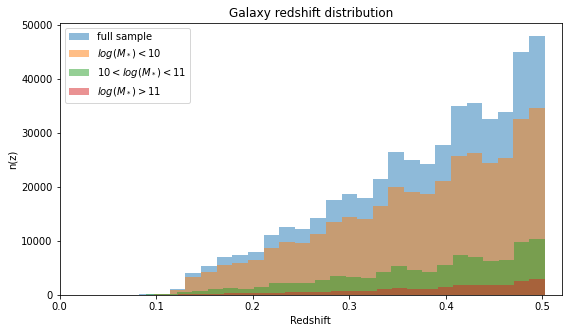

In [ ]:
plt.figure(figsize=(9, 5))
plt.hist( redshift, bins = 30, label='full sample', alpha=0.5);
plt.hist( redshift[np.where( np.log10(stellar_mass) < 10) ], bins = 30, label=r'$log(M_*) < 10$', alpha=0.5);
plt.hist( redshift[np.where( (np.log10(stellar_mass) > 10) & (np.log10(stellar_mass) < 11) )], bins = 30, label=r'$10< log(M_*) < 11$', alpha=0.5);
plt.hist( redshift[np.where( np.log10(stellar_mass) > 11) ], bins = 30, label=r'$log(M_*) > 11$', alpha=0.5);


plt.title('Galaxy redshift distribution')
plt.xlabel('Redshift')
plt.ylabel('n(z)')
plt.xlim(0, 0.52)
plt.legend()

### 7. Galaxy stellar mass functions

<matplotlib.legend.Legend>

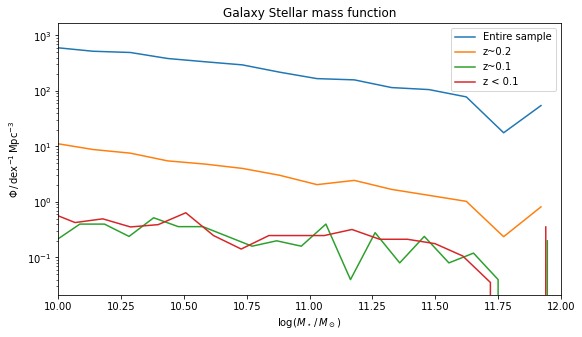

In [ ]:
def GSMF(sm):
    logsm = np.log10(sm)
    V     = 256                             #Survey volume in Mpc3
    Phi, bin_edges = np.histogram(logsm ,bins= 30) #Unnormalized histogram and bin edges
    dM    = bin_edges[1] - bin_edges[0]                 #Bin size
    Max   = bin_edges[0:-1] + dM/2.               #Mass axis
    Phi   = Phi / V / dM                    #Normalize to volume and bin size
    return Max, Phi


Max, Phi = GSMF(stellar_mass[stellar_mass > 9])
Max0_2, Phi0_2 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 0.21) &(redshift > 0.19)])
Max0_1, Phi0_1 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 0.11) &(redshift > 0.09)])
Max0_05, Phi0_05 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 0.1) &(redshift > 0.000)])


plt.figure(figsize=(9, 5))
plt.title('Galaxy Stellar mass function')
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')

plt.plot( Max, Phi , ls='-', label='Entire sample')
plt.plot( Max0_2, Phi0_2 , ls='-', label='z~0.2')
plt.plot( Max0_1, Phi0_1 , ls='-', label='z~0.1')
plt.plot( Max0_05, Phi0_05 , ls='-', label='z < 0.1')

plt.xlim(10, 12)

plt.legend()

### 8. Two-point correlation function (may not be accurate)

In [ ]:
from scipy.integrate import quad

# Define cosmological parameters for a standard Lambda-CDM model
H0 = 70.0  # Hubble constant at z=0 in km/s/Mpc
Om0 = 0.3  # Matter density parameter
c = 299792.458  # Speed of light in km/s

# Define the comoving distance integral
def integrand(z):
    Ez = (Om0 * (1 + z)**3 + (1 - Om0))**0.5
    return c / (H0 * Ez)

# Compute comoving distance for each redshift value
comoving_distances = np.array([quad(integrand, 0, z)[0] for z in redshift])

# Convert RA, Dec, and comoving distance to Cartesian coordinates
ra_rad = np.deg2rad(ra_full)
dec_rad = np.deg2rad(dec_full)

x = comoving_distances * np.cos(dec_rad) * np.cos(ra_rad)
y = comoving_distances * np.cos(dec_rad) * np.sin(ra_rad)
z = comoving_distances * np.sin(dec_rad)

# For computation time considerations, use a subset of the data
subset_indices = np.random.choice(len(x), size=len(x), replace=False)
x_subset = x[subset_indices]
y_subset = y[subset_indices]
z_subset = z[subset_indices]

In [ ]:
from scipy.spatial import cKDTree

def compute_pair_counts(points, bins):
    """Compute the pair counts for a set of points using a KDTree."""
    tree = cKDTree(points)
    return tree.count_neighbors(tree, bins, cumulative=False)

# Define the bin edges for separation r
bins = np.logspace(0.01, 2, 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Compute DD(r) for the observed data subset
observed_points = np.vstack((x_subset, y_subset, z_subset)).T
DD = compute_pair_counts(observed_points, bins)

# Generate a random sample of points in the same volume
random_points = np.vstack((
    np.random.uniform(min(x_subset), max(x_subset), len(x_subset)),
    np.random.uniform(min(y_subset), max(y_subset), len(x_subset)),
    np.random.uniform(min(z_subset), max(z_subset), len(x_subset))
)).T

# Compute RR(r) for the random sample
RR = compute_pair_counts(random_points, bins)

# Compute the two-point correlation function
xi = DD / RR - 1

# Remove the last value of xi to match the size of bin_centers
xi = xi[:-1]

In [ ]:
# Compute DR(r) for the observed data subset and the random sample
DR = cKDTree(observed_points).count_neighbors(cKDTree(random_points), bins)

# Compute the two-point correlation function using Landy-Szalay estimator
xi_Landy_Szalay = (DD - 2*DR + RR) / RR

xi_Landy_Szalay = xi_Landy_Szalay[:-1]

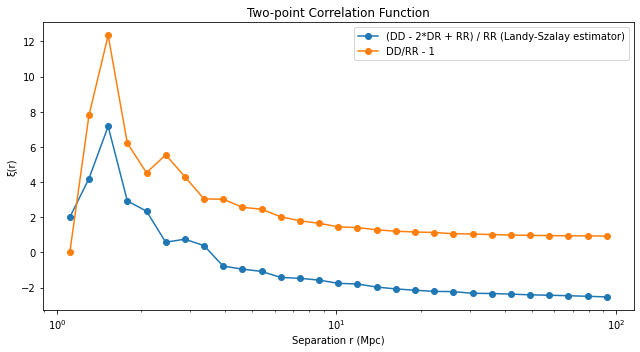

In [ ]:
# Plot the two-point correlation function
plt.figure(figsize=(9, 5))
plt.plot(bin_centers, xi_Landy_Szalay, marker='o', linestyle='-', label='(DD - 2*DR + RR) / RR (Landy-Szalay estimator)')
plt.plot(bin_centers, xi, marker='o', linestyle='-', label='DD/RR - 1')

plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Separation r (Mpc)')
plt.ylabel('ξ(r)')
plt.title('Two-point Correlation Function')
# plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

### We also provide auxilary pickle files for information about the survey

In [ ]:
import pickle 

def load_survey_pickle(survey):
        
    if (survey=='LSST'):
        FILTER_NAME = 'LSST.pickle'
    elif (survey=='SPHEREx'):
        FILTER_NAME = 'SPHEREx.pickle'
    elif (survey=='COSMOS'):
        FILTER_NAME = 'COSMOS.pickle'
    else: 
        raise NotImplementedError("Filter specifications not included")
        
    with open(FILTER_NAME, 'rb') as f:
     central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = pickle.load(f)
    
    return central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names

In [ ]:
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('SPHEREx')

### 9. Reading spherex bandpasses, plotting number densities in (color vs redshift) plot 

In [ ]:
mag_spherex_0 = np.array(test_data['mag_0_spherex'])
mag_spherex_1 = np.array(test_data['mag_1_spherex'])
mag_spherex_2 = np.array(test_data['mag_2_spherex'])
mag_spherex_3 = np.array(test_data['mag_3_spherex'])
mag_spherex_4 = np.array(test_data['mag_4_spherex'])
mag_spherex_5 = np.array(test_data['mag_5_spherex'])
mag_spherex_6 = np.array(test_data['mag_6_spherex'])
mag_spherex_7 = np.array(test_data['mag_7_spherex'])
mag_spherex_8 = np.array(test_data['mag_8_spherex'])

s1 = np.array([mag_spherex_0, mag_spherex_1, mag_spherex_2, mag_spherex_3, mag_spherex_4, mag_spherex_5, mag_spherex_6, mag_spherex_7, mag_spherex_8, redshift]).T
allLabels = [ 'Mag(' +str(i+1)+ ') - Mag(' +str(i)+ ')' for i in range(s1.shape[1] - 1)]

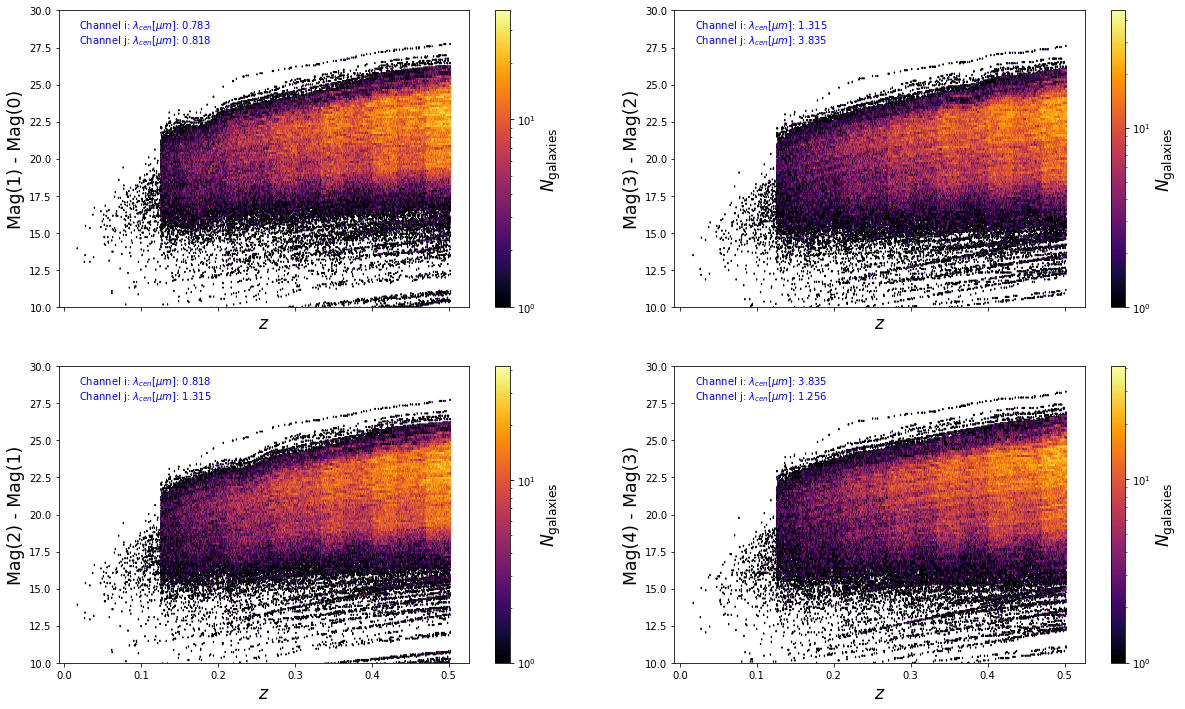

In [ ]:
ncols = 2
nrows = 2

f, a = plt.subplots(ncols= ncols, nrows = nrows, sharex = True, figsize=(ncols*8, nrows*6))
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.01, right=0.99)

for col_idx in range(ncols):
    for row_idx in range(nrows):

        band_idx = row_idx*nrows + col_idx
        hb = a[col_idx, row_idx].hexbin(s1[:, -1], s1[:, band_idx], gridsize= 1000,  bins='log', cmap='inferno')
        a[col_idx, row_idx].set_xlabel(r'$z$', fontsize = "xx-large")
        a[col_idx, row_idx].set_ylabel(allLabels[band_idx], fontsize = "xx-large")
        #a[col_idx, row_idx].text(0.2, 0.9, allLabels[band_idx], horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='white')
        # a[col_idx, row_idx].text(0.05, 0.9, 'channel i (µm): ' + str(lambda_min[band_idx]) + ' -- ' + str(lambda_max[band_idx]) , horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='white')
        a[col_idx, row_idx].text(0.05, 0.95, 
                                 r'Channel i: $\lambda_{cen} [\mu m]$: ' 
                                 + str( round(central_wavelengths[band_idx], 3)),
                                 horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='blue')

        
        a[col_idx, row_idx].text(0.05, 0.9, 
                                 r'Channel j: $\lambda_{cen} [\mu m]$: ' 
                                 + str( round(central_wavelengths[band_idx + 1], 3)),
                                 horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='blue')
        #a[col_idx, row_idx].set(aspect='equal')
        cb = f.colorbar(hb, ax=a[col_idx, row_idx])
        cb.set_label(r'$N_{\rm galaxies}$', fontsize = "xx-large")
        a[col_idx, row_idx].set_ylim(10, 30)